### Introduction to Statistical Learning with R
# Lab 9: Support Vector Machines
#### Completed in Jupyter notebook by Austin Welch
<br>

## 9.6.1 Support Vector Classifier

The `e1071` library contains implementations for a number of statistical learning methods. In particular, the `svm()` function can be used to fit a support vector classifier when the argument `kernel="linear"` is used. This function uses a slightly different formulation from (9.14) and (9.25) for the support vector classifier. A `cost` argument allows us to specify the cost of a violation to the margin. When the `cost` argument is small, then the margins will be wide and many support vectors will be on the margin or will violate the margin. When the `cost` is large, then the margins will be narrow and there will be few support vectors on the margin or violating the margin. 

We now use the `svm()` function to fit the support vector classifier for a given value of the `cost` parameter. Here we demonstrate the use of this function on a two-dimensional example so that we can plot the resulting decision boundary. We begin by generating the observations, which belong to two clases, and checking whether the classes are linearly separable.

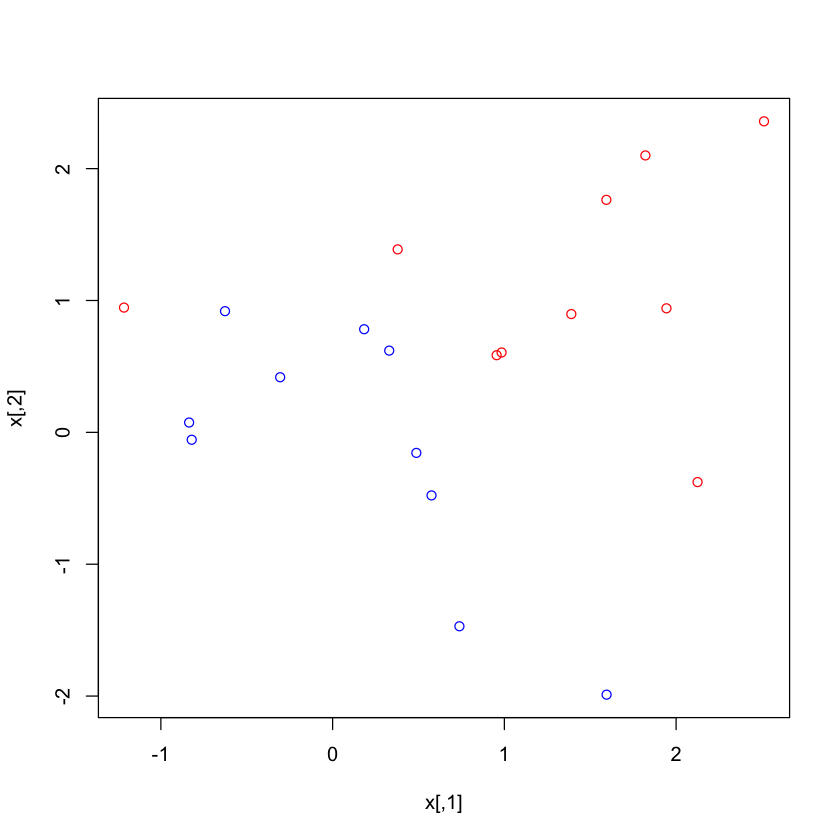

In [1]:
set.seed(1)
x=matrix(rnorm(20*2), ncol=2) # 40 normal RVs
y=c(rep(-1,10), rep(1,10))
x[y==1,]=x[y==1,] + 1
plot(x, col=(3-y)) # color

They are not. Next, we fit the support vector classifier. Note that in order for the `svm()` function to perform classification (as opposed to SVM-based regression), we must encode the response as a factor variable. We now create a data frame with the response coded as a factor. 

In [21]:
dat=data.frame(x=x, y=as.factor(y)) # encode a vector as a factor (the terms ‘category’ and ‘enumerated type’ are also used for factors)
library(e1071)
svmfit=svm(y~., data=dat, kernel="linear", cost=10, scale=FALSE)

The argument `scale=FALSE` tells the `svm()` function not to scale each feature to have mean zero or standard deviation one; depending on the application, one might prefer to use `scale=TRUE`. 

We can now plot the support vector classifier obtained:

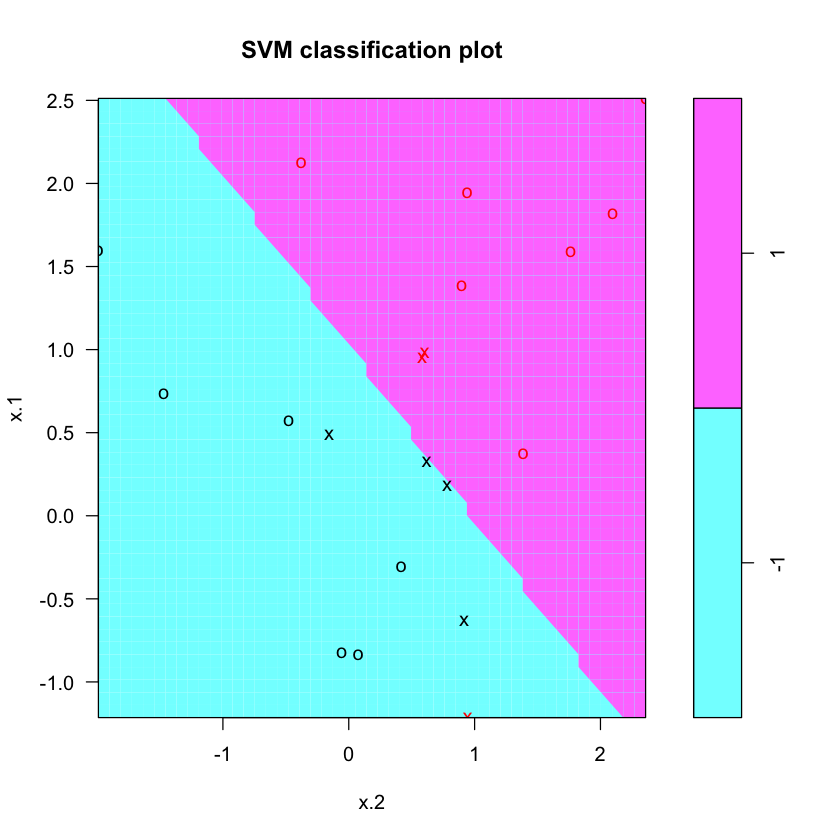

In [22]:
plot(svmfit, dat)

Note that the two arguments to the `plot.svm()` function are the output of the call to `svm()`, as well as the data used in the call to `svm()`. The region of feature space that will be assigned to the -1 class is shown in light blue, and the region that will be assigned to the +1 class is shown in purple. The decision boundary between the two classes is linear (because we used the argument `kernel="linear"`), though due to the way in which the plotting function is implemented in this library the decision boundary looks somewhat jagged in the plot. We see that in this case only one observation is misclassified. (Note that here the second feature is plotted on the x-axis and the fiest feature is plotted on the y-axis, in contrast to the behavior of the usual `plot()` function in R.) The support vectors are plotted as crosses and the remaining observations are plotted as circles; we see here that there are seven support vectors. We can determine their identities as follows:

In [23]:
svmfit$index

[1]  1  2  5  7 14 16 17

We can obtain some basic information about the support vector classifier fit using the `summary()` command:

In [24]:
summary(svmfit)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.5 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




This tells us, for instance, that a linear kernel was used with `cost=10`, and that there were seven support vectors, four in one class and three in the other. 

What if we instead used a smaller value of the cost parameter?

[1]  1  2  3  4  5  7  9 10 12 13 14 15 16 17 18 20

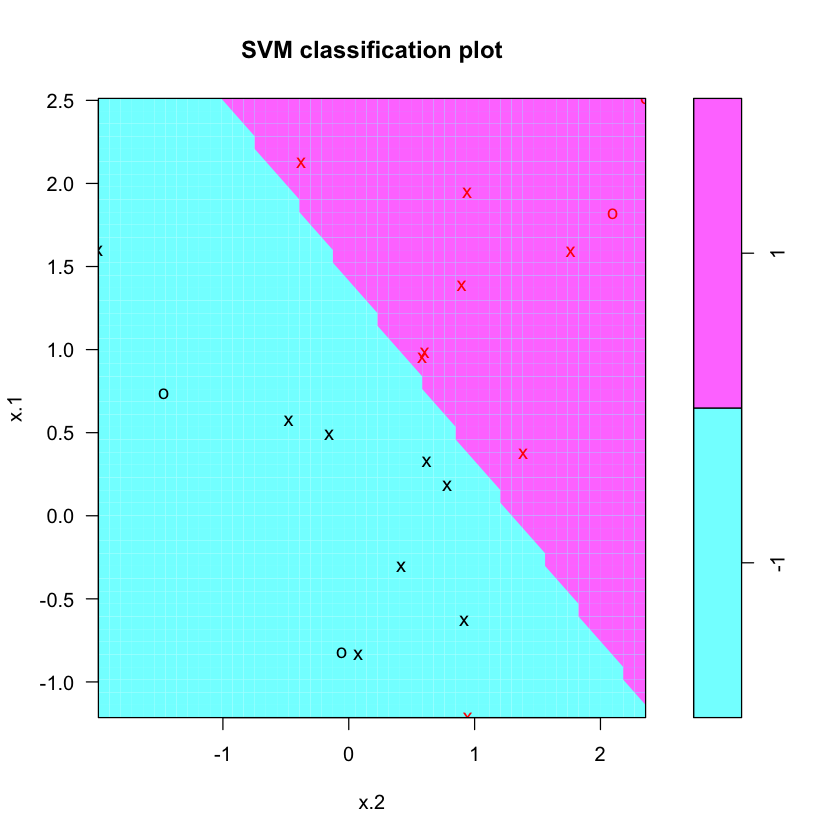

In [25]:
svmfit=svm(y~., data=dat, kernel="linear", cost=0.1, scale=FALSE)
plot(svmfit, dat)
svmfit$index

Now that a smaller value of the cost parameter is being used, we obtain a larger number of support vectors, because the margin is now wider. Unfortunately, the `svm()` function does not explicity output the coefficients of the linear decision boundary obtained when the support vector classifier is fit, nor does it output the width of the margin. 

The `e1071` library includes a built-in function, `tune()`, to perform cross-validation. By default, `tune()` performs ten-fold cross-validation on a set of models of interest. In order to use this function, we pass in relevant information about the set of models that are under consideration. The following command indicates that we want to compare SVMs with a linear kernel, using a range of values of the `cost` parameter.

In [26]:
set.seed(1)
tune.out=tune(svm,y~.,data=dat,kernel="linear",
              ranges=list(cost=c(0.001,0.01,0.1,1,5,10,100)))

We can easily access the cross-validation errors for each of these models using the `summary()` command:

In [27]:
summary(tune.out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.1 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.70  0.4216370
2 1e-02  0.70  0.4216370
3 1e-01  0.10  0.2108185
4 1e+00  0.15  0.2415229
5 5e+00  0.15  0.2415229
6 1e+01  0.15  0.2415229
7 1e+02  0.15  0.2415229


We see that `cost=0.1` results in the lowest cross-validation error rate. The `tune()` function stores the best model obtained, which can be accessed as follows:

In [28]:
bestmod=tune.out$best.model
summary(bestmod)


Call:
best.tune(method = svm, train.x = y ~ ., data = dat, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 
      gamma:  0.5 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




The `predict()` function can be used to predict the class label on a set of test observations, at any given value of the cost parameter. We begin by generating a test data set.

In [29]:
xtest=matrix(rnorm(20*2),ncol=2)
ytest=sample(c(-1,1), 20, rep=TRUE)
xtest[ytest==1,]=xtest[ytest==1,] + 1
testdat=data.frame(x=xtest,y=as.factor(ytest))

Now we predict the class labels of these test observations. Here we use the best model obtained through cross-validation in order to make predictions.

In [30]:
ypred=predict(bestmod,testdat)
table(predict=ypred,truth=testdat$y)

       truth
predict -1  1
     -1 11  1
     1   0  8

Thus, with this value of `cost`, 19 of the test observations are correctly classified. What if we had instead used `cost=0.01`?

In [31]:
svmfit=svm(y~., data=dat, kernel="linear", cost=.01, scale=FALSE)
ypred=predict(svmfit,testdat)
table(predict=ypred,truth=testdat$y)

       truth
predict -1  1
     -1 11  2
     1   0  7

In this case one additional observation is misclassified.

Now consider a situation in which the two classes are linearly separable. Then we can find a separating hyperplane using the `svm()` function. We first further separate the two classes in our simulated data so that they are linearly separable:

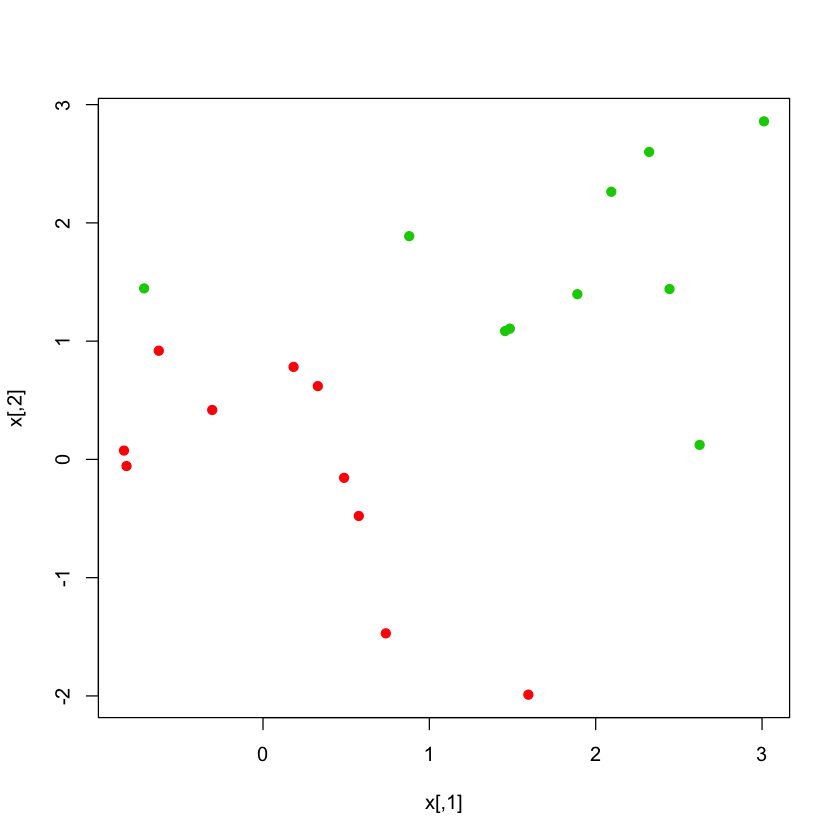

In [32]:
x[y==1,]=x[y==1,]+0.5
plot(x,col=(y+5)/2,pch=19)

Now the observations are just barely linearly separable. We fit the support vector classifier and plot the resulting hyperplane, using a very large value of `cost` so that no observations are misclassified.


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 1e+05)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1e+05 
      gamma:  0.5 

Number of Support Vectors:  3

 ( 1 2 )


Number of Classes:  2 

Levels: 
 -1 1




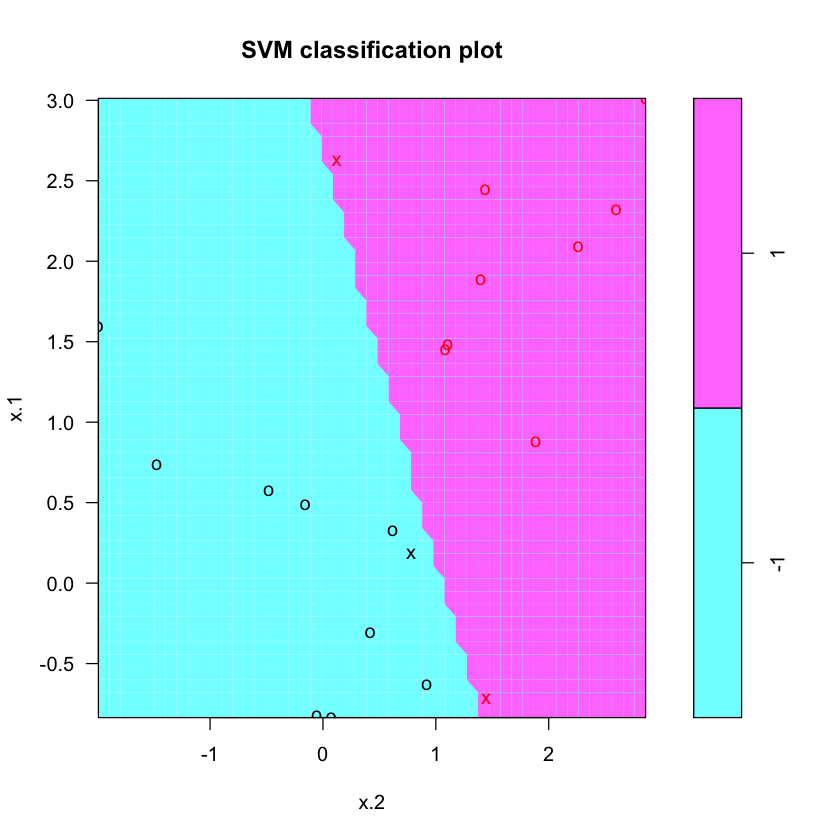

In [36]:
dat=data.frame(x=x,y=as.factor(y))
svmfit=svm(y~.,data=dat,kernel="linear",cost=1e5)
summary(svmfit)
plot(svmfit,dat)

No training errors were made and only three support vectors were used. However, we can see from the figure that the margin is very narrow (because the observations that are not support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform poorly on test data. We now try a smaller value of `cost`:


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.5 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




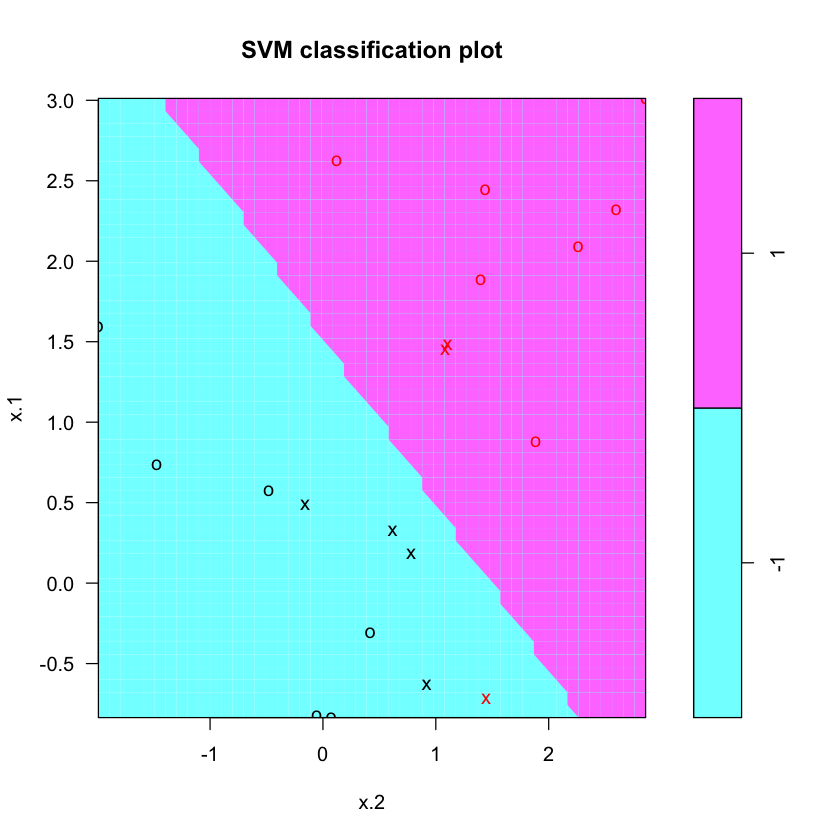

In [38]:
svmfit=svm(y~.,data=dat,kernel="linear",cost=1)
summary(svmfit)
plot(svmfit,dat)

Using `cost=1`, we misclassify a training observation, but we also obtain a much wider margin and make use of seven support vectors. In seems likely that this model will perform better on test data than the model with `cost=1e5`.

<br>
## 9.6.2 Support Vector Machine

In order to fit an SVM using a non-linear kernel, we once again use the `svm()` function. However, now we use a different value of the parameter `kernel`. To fit an SVM with a polynomial kernel we use `kernel="polynomial"`, and to fit an SVM with a radial kernel we use `kernel="radial"`, In the former case we also use the `degree` argument to specify a degree for the polynomial kernel (this is *d* in (9.22)), and in the latter case we use `gamma` to specify a value of $\gamma$ for the radial basis kernel (9.24). 

We first generate some data with non-linear class boundary, as follows:

In [39]:
set.seed(1)
x=matrix(rnorm(200*2),ncol=2)
x[1:100,]=x[1:100,]+2
x[101:150,]=x[101:150]-2
y=c(rep(1,150),rep(2,50))
dat=data.frame(x=x,y=as.factor(y))

Plotting the data makes it clear that the class boundary is indeed non-linear:

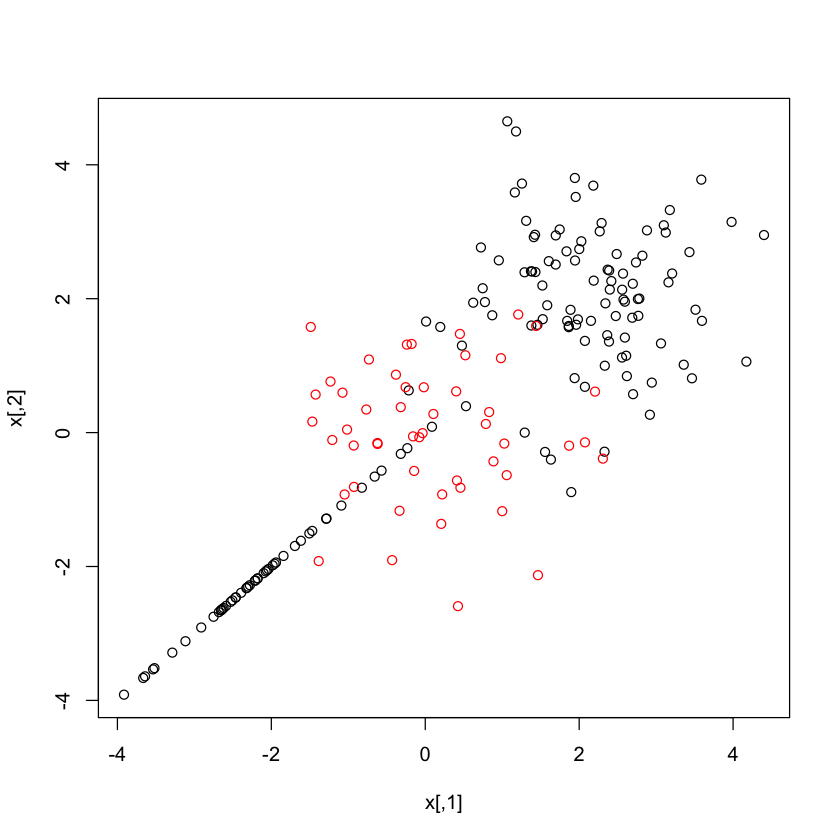

In [40]:
plot(x,col=y)

The data is randomly split into training and testing groups. We then fit the training data using the `svm()` function with a radial kernel and $\gamma=1$:

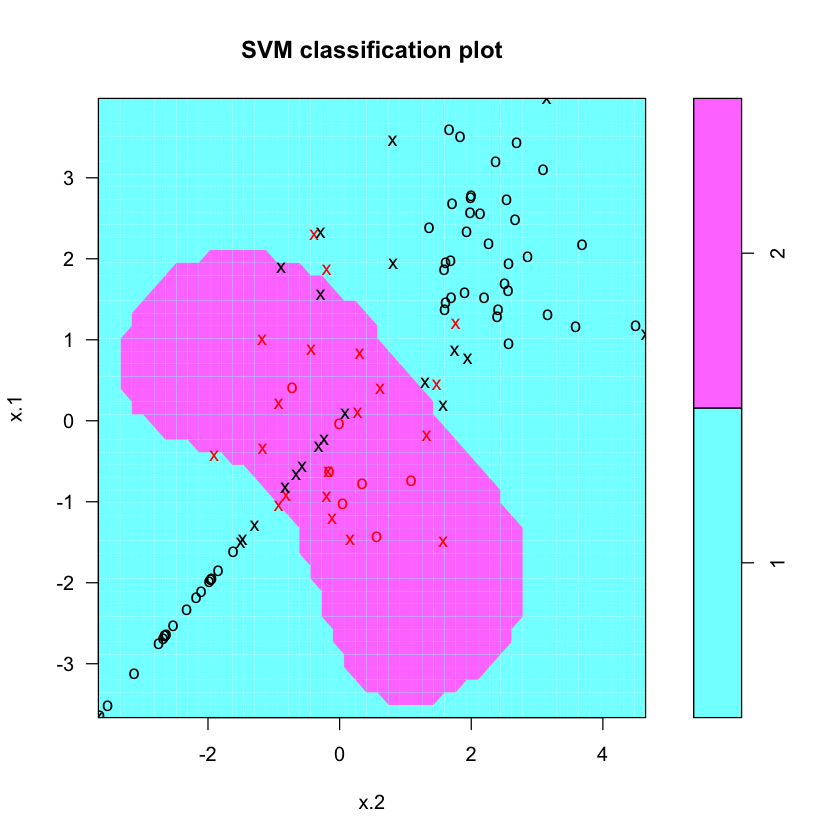

In [41]:
train=sample(200,100)
svmfit=svm(y~.,data=dat[train,],kernel="radial",gamma=1,cost=1)
plot(svmfit,dat[train,])

The plot shows that the resulting SVM has a decidedly non-linear boundary. The `summary()` function can be used to obtain some information about the SVM fit:

In [42]:
summary(svmfit)


Call:
svm(formula = y ~ ., data = dat[train, ], kernel = "radial", gamma = 1, 
    cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  1 

Number of Support Vectors:  41

 ( 20 21 )


Number of Classes:  2 

Levels: 
 1 2




We can see from the figure that there are a fair number of training errors in this SVM fit. If we increase the value of `cost`, we can reduce the number of training errors. However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data.

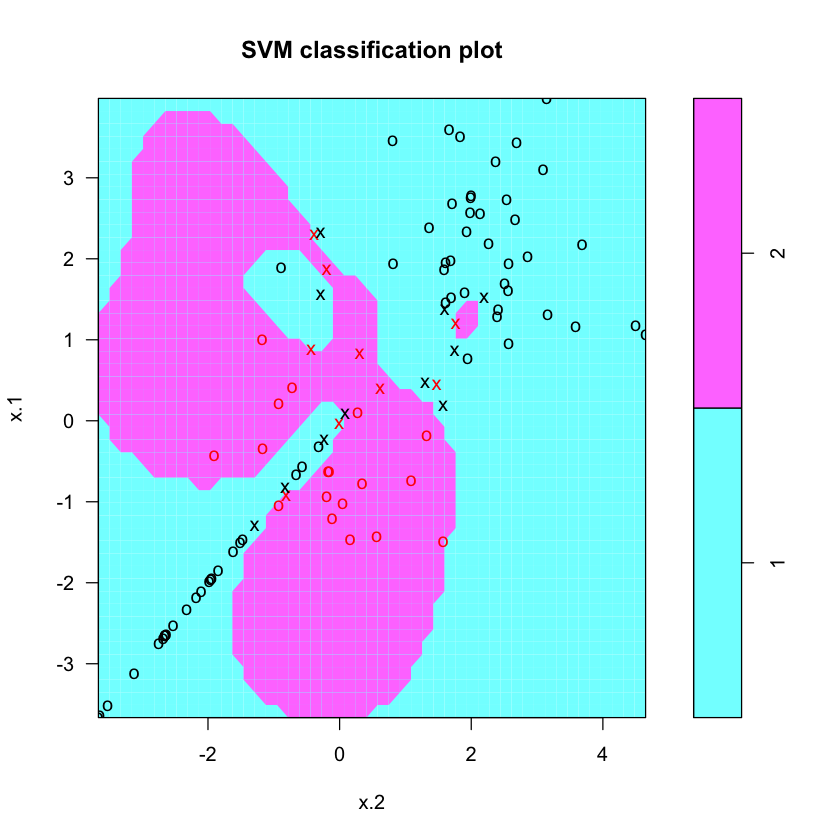

In [43]:
svmfit=svm(y~.,data=dat[train,],kernel="radial",gamma=1,cost=1e5)
plot(svmfit,dat[train,])

We can perform cross-validation using `tune()` to select the best choice of $\gamma$ and `cost` for an SVM with a radial kernel:

In [47]:
set.seed(1)
tune.out=tune(svm,y~.,data=dat[train,],kernel="radial",
             ranges=list(cost=c(0.1,1,10,100,1000),gamma=c(0.5,1,2,3,4)))
summary(tune.out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.15 

- Detailed performance results:
    cost gamma error dispersion
1  1e-01   0.5  0.27 0.11595018
2  1e+00   0.5  0.15 0.08498366
3  1e+01   0.5  0.16 0.08432740
4  1e+02   0.5  0.19 0.09944289
5  1e+03   0.5  0.19 0.09944289
6  1e-01   1.0  0.27 0.11595018
7  1e+00   1.0  0.16 0.09660918
8  1e+01   1.0  0.19 0.13703203
9  1e+02   1.0  0.18 0.09189366
10 1e+03   1.0  0.18 0.10327956
11 1e-01   2.0  0.27 0.11595018
12 1e+00   2.0  0.18 0.11352924
13 1e+01   2.0  0.20 0.09428090
14 1e+02   2.0  0.17 0.09486833
15 1e+03   2.0  0.15 0.10801234
16 1e-01   3.0  0.27 0.11595018
17 1e+00   3.0  0.18 0.11352924
18 1e+01   3.0  0.16 0.08432740
19 1e+02   3.0  0.18 0.10327956
20 1e+03   3.0  0.20 0.11547005
21 1e-01   4.0  0.27 0.11595018
22 1e+00   4.0  0.19 0.13703203
23 1e+01   4.0  0.17 0.06749486
24 1e+02   4.0  0.17 0.09486833
25 1e+03   4.0  0.23 0

Therefore, the best choice of parameters involves `cost=1` and `gamma=2`. We can view the test set predictions for this model by applying the `predict()` function to the data. Notice that to do this we subset the dataframe `dat` using `-train` as an index set.

In [53]:
table(true=dat[-train,"y"],pred=predict(tune.out$best.model,newdata=dat[-train,]))

    pred
true  1  2
   1 71  6
   2  5 18

10% of test observations are misclassified by this SVM.

<br>
## 9.6.3 ROC Curves

The `ROCR` package can be used to produce ROC curves such as those in Figures 9.10 and 9.11. We first write a short function to plot an ROC curve given a vector containing a numerical score for each observation, `pred`, and a vector containing the class label for each observation, `truth`.

In [57]:
library(ROCR)
rocplot=function(pred, truth, ...){
    predob = prediction(pred, truth)
    perf = performance(predob, "tpr", "fpr")
    plot(perf,...)
}

SVMs and support vector classifiers output class labels for each observation. However, it is also possible to obtain *fitted values* for each observation, which are the numerical scores used to obtain the class labels. For instance, in the case of a support vector classifier, the fitted value for an observation $X=(X_{1},X_{2},...,X_{p})^{T}$ takes the form $\hat{\beta_{0}}+\hat{\beta_{1}}X_{1}+\hat{\beta_{2}}X_{2}+...+\hat{\beta_{p}}X_{p}$. For an SVM with a non-linear kernel, the equation that yields the fitted value is given in (9.23). In essence, the sign of the fitted value determines on which side of the decision boundary the observation lies. Therefore, the relationship between the fitted value and the class prediction for a given observation is simple: if the fitted value exceeds zero then the observation is assigned to one class, and if it is less than zero then it is assigned to the other. In order to obtain the fitted values for a given SVM model fit, we use `decision.values=TRUE` when fitting `svm()`. Then the `predict()` function will output the fitted values.

In [68]:
svmfit.opt=svm(y~.,data=dat[train,],kernel="radial",gamma=2,cost=1,decision.values=T)
fitted=attributes(predict(svmfit.opt,dat[train,],decision.values=TRUE))$decision.values

Now we can produce the ROC plot.

SVM appears to be producing accurate predictions. By increasing $\gamma$ we can produce a more flexible fit and generate further improvements in accuracy.

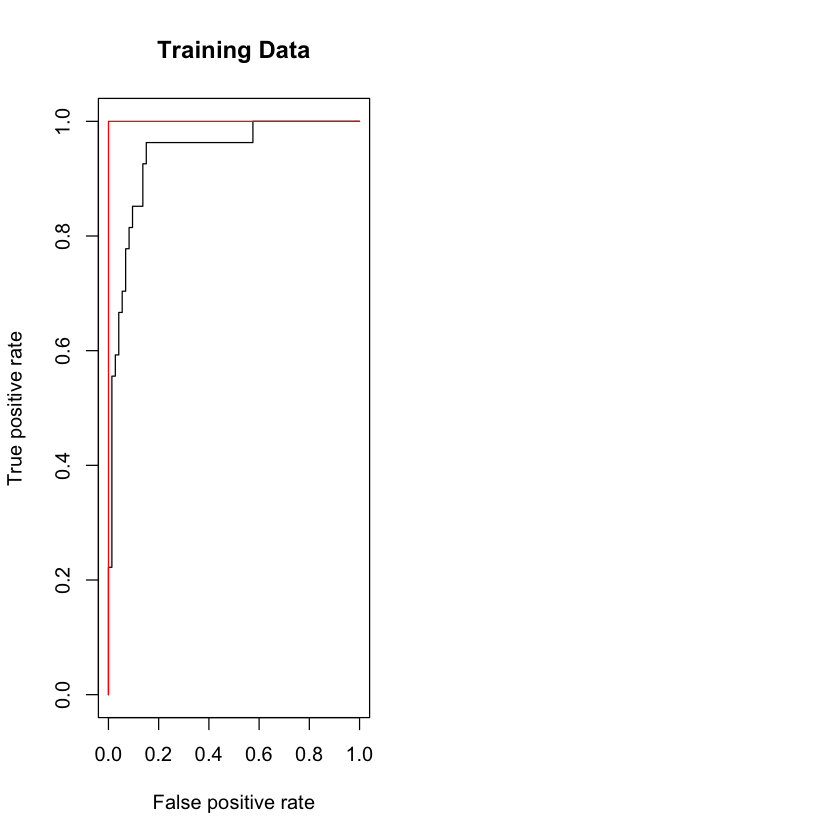

In [70]:
par(mfrow=c(1,2))
rocplot(fitted,dat[train,"y"],main="Training Data")

svmfit.flex=svm(y~.,data=dat[train,],kernel="radial",gamma=500,cost=1,decision.values=T)
fitted=attributes(predict(svmfit.flex,dat[train,],decision.values=T))$decision.values
rocplot(fitted,dat[train,"y"],add=T,col="red")

However, these ROC curves are all on thr training data. We are really more intested in the level of prediction accuracy on the test data. When we comput ethr ROC curves on the test data, the model with $\gamma=2$ appears to provide the most accurate results.

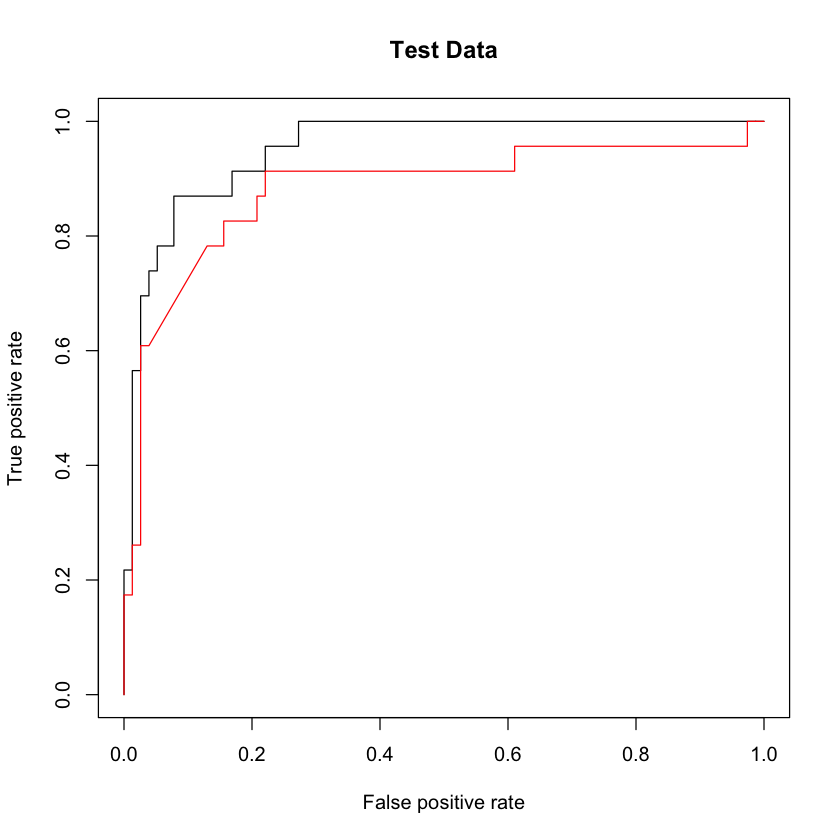

In [71]:
fitted=attributes(predict(svmfit.opt,dat[-train,],decision.values=T))$decision.values
rocplot(fitted,dat[-train,"y"],main="Test Data")
fitted=attributes(predict(svmfit.flex,dat[-train,],decision.values=T))$decision.values
rocplot(fitted,dat[-train,"y"],add=T,col="red")

<br>
## 9.6.4 SVM with Multiple Classes

If the response is a factor containing more than two levels, then the `svm()` function will perform multi-class classification using the one-versus-one approach. We explore that setting here by generating a third class of observations.

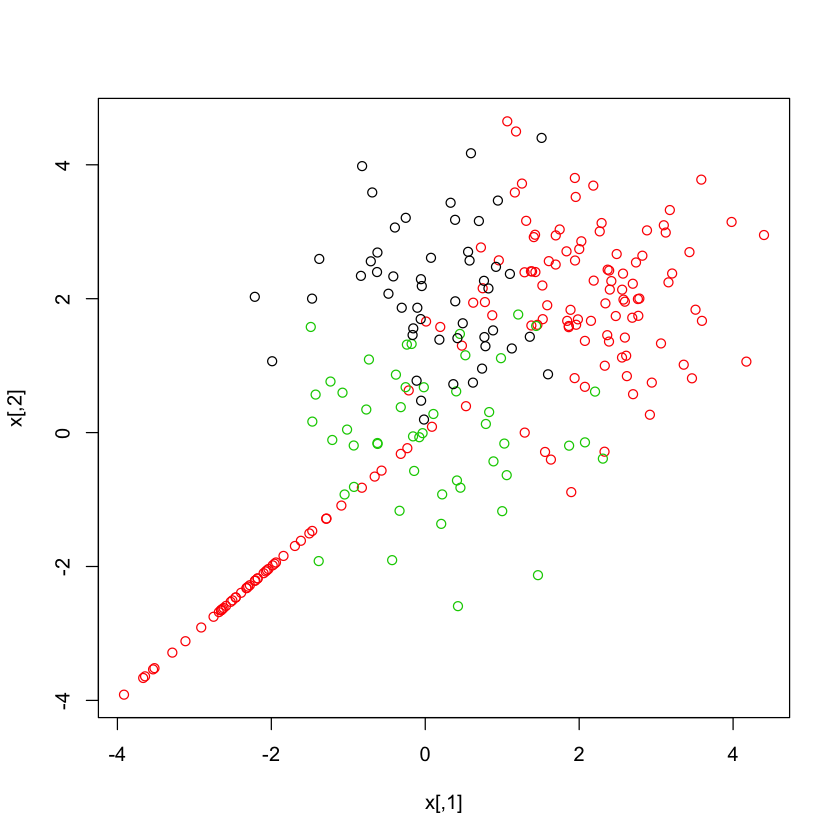

In [72]:
set.seed(1)
x=rbind(x,matrix(rnorm(50*2),ncol=2))
y=c(y,rep(0,50))
x[y==0,2]=x[y==0,2]+2
dat=data.frame(x=x,y=as.factor(y))
par(mfrow=c(1,1))
plot(x,col=(y+1))

We now fit an SVM to the data:

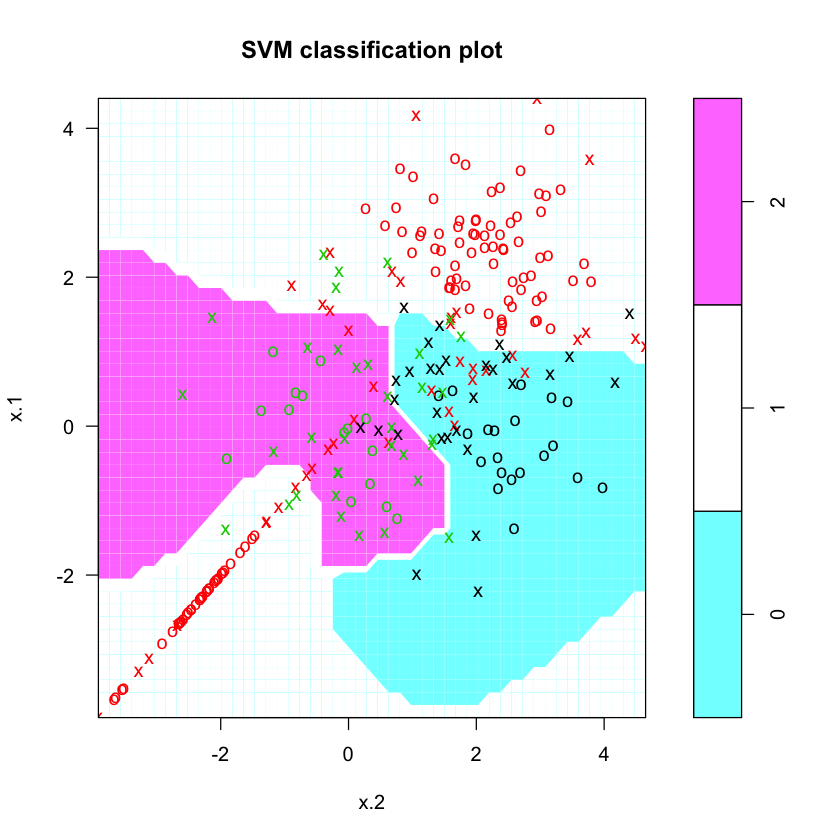

In [73]:
svmfit=svm(y~.,data=dat,kernel="radial",cost=10,gamma=1)
plot(svmfit,dat)

The `e1071` library can also be used to perform support vector regression, if the response vector that is pased in to `svm()` is numerical rather than a factor.

<br>
## 9.6.5 Application to Gene Expression Data

We now examine the `Khan` data set, which consists of a number of tissue samples corresponding to four distinct types of small round blue cell tumors. For each tissue sample, gene expression measurements are available. The data set consists of training data, `xtrain` and `ytrain`, and testing data, `xtest` and `ytest`. 

We examine the dimension of the data:

In [74]:
library(ISLR)
names(Khan)
dim(Khan$xtrain)
dim(Khan$xtest)
length(Khan$ytrain)
length(Khan$ytest)

[1] "xtrain" "xtest"  "ytrain" "ytest"

[1]   63 2308

[1]   20 2308

[1] 63

[1] 20

This data set consists of expression measurements for 2,308 genes. The training and test sets consist of 63 and 20 observations respectively.

In [75]:
table(Khan$ytrain)
table(Khan$ytest)


 1  2  3  4 
 8 23 12 20 


1 2 3 4 
3 6 6 5 

We will use a support vector approach to predict cancer subtype using gene expression measurements. In this data set, there are a very large number of features relative to the number of observations. This suggests that we should use a linear kernel, because the additional flexibility that will result from using a polynomial or radial kernel is unnecessary.

In [76]:
dat=data.frame(x=Khan$xtrain,y=as.factor(Khan$ytrain))
out=svm(y~., data=dat,kernel="linear",cost=10)
summary(out)
table(out$fitted,dat$y)


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.0004332756 

Number of Support Vectors:  58

 ( 20 20 11 7 )


Number of Classes:  4 

Levels: 
 1 2 3 4




   
     1  2  3  4
  1  8  0  0  0
  2  0 23  0  0
  3  0  0 12  0
  4  0  0  0 20

We see that there are *no* training errors. In fact, this is not suprising, because the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes. We are most interested not in the support vector classifier's performance on the training observations, but rather its performance on the test observations.

In [78]:
dat.te=data.frame(x=Khan$xtest,y=as.factor(Khan$ytest))
pred.te=predict(out,newdata=dat.te)
table(pred.te,dat.te$y)

       
pred.te 1 2 3 4
      1 3 0 0 0
      2 0 6 2 0
      3 0 0 4 0
      4 0 0 0 5

We see that using `cost=10` yields two test set errors on this data.